## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading the model and data

In [3]:
model_lgb = None
X_test = None
final_df = None

# --- Load the Model ---
try:
    model_lgb = joblib.load('lightgbm_model.joblib')
except Exception as e:
    print(f"ERROR loading model_lgb: {e}")

# --- Load X_test ---
try:
    X_test = pd.read_parquet('X_test_model_features.parquet')
except Exception: # Broad exception to catch FileNotFoundError or Parquet read errors
    try:
        X_test = pd.read_csv('X_test_model_features.csv')
    except Exception as e_csv:
        print(f"ERROR loading X_test (tried Parquet and CSV): {e_csv}")

# --- Load final_df ---
try:
    final_df = pd.read_parquet('final_df_for_analysis.parquet')
except Exception: # Broad exception
    try:
        final_df = pd.read_csv('final_df_for_analysis.csv')
        if final_df is not None and 'DateOfReport' in final_df.columns: # Check if df loaded
            final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'], errors='coerce')
    except Exception as e_csv:
        print(f"ERROR loading final_df (tried Parquet and CSV): {e_csv}")

# --- Check if all loaded successfully before proceeding ---
if model_lgb is not None and X_test is not None and final_df is not None:
    # Proceed with your stratification logic using model_lgb, X_test, final_df
    # print("All components loaded successfully.") # Optional: uncomment for a success message
    pass
else:
    print("One or more essential components failed to load. Cannot proceed with analysis.")

In [4]:
# --- Step 1: Configuration for Stratification ---
probability_class_idx_for_strata = 0
strata_config = {
    'labels': ['Lowest_Risk', 'Low_Risk', 'Medium_Risk', 'High_Risk', 'Highest_Risk'],
    'quantiles': [0, 0.05, 0.25, 0.75, 0.95, 1.0]
}
# Dynamically create the names for the new columns
proba_col_name = f'probability_class{probability_class_idx_for_strata}'
stratum_col_name = f'stratum_class{probability_class_idx_for_strata}' # This is THE key variable

# --- Step 2: Function to Assign Strata ---
def assign_strata_from_probabilities(
    trained_model, features_for_prediction, df_to_add_strata_to,
    prob_class_idx, strata_definition, new_proba_col_name, new_stratum_col_name
):
    all_class_probs = trained_model.predict_proba(features_for_prediction)
    selected_probs = all_class_probs[:, prob_class_idx]
    output_df = df_to_add_strata_to.copy()
    output_df[new_proba_col_name] = selected_probs
    try:
        output_df[new_stratum_col_name] = pd.qcut(
            output_df[new_proba_col_name], q=strata_definition['quantiles'],
            labels=strata_definition['labels'], duplicates='drop'
        )
    except Exception:
        output_df[new_stratum_col_name] = np.nan
    return output_df

# --- Step 3: Create the Stratified DataFrame ---
stratified_df = None # Initialize
if ('model_lgb' in locals() and
    'X_test' in locals() and isinstance(X_test, pd.DataFrame) and
    'final_df' in locals() and isinstance(final_df, pd.DataFrame)):

    # Ensure DateOfReport is datetime in final_df if it's going to be used for filtering
    if 'DateOfReport' in final_df.columns and final_df['DateOfReport'].dtype != '<M8[ns]':
         final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'])
    if 'SupplierName' not in final_df.columns: # Basic check
        print("Warning: 'SupplierName' not found in final_df. Supplier filtering will not work.")


    stratified_df = assign_strata_from_probabilities(
        model_lgb, X_test, final_df, probability_class_idx_for_strata,
        strata_config, proba_col_name, stratum_col_name
    )
else:
    print("Initial setup skipped: Required variables (model_lgb, X_test, final_df) not found or not of correct type.")

## Stratification

In [5]:
def print_stratum_distribution(df, column_name, config_labels, description="Data"):
    if df is None or df.empty:
        print(f"No data for: {description}")
        return
    if column_name not in df.columns or df[column_name].isnull().all():
        print(f"Stratum column '{column_name}' missing or all NaNs for: {description}")
        return

    print(f"\n--- Stratum Distribution for: {description} (Total: {df.shape[0]}) ---")
    counts = df[column_name].value_counts().sort_index()
    percentages = df[column_name].value_counts(normalize=True).sort_index() * 100
    for label in config_labels:
        c = counts.get(label, 0)
        p = percentages.get(label, 0.0)
        print(f"  {label}: {c} ({p:.2f}%)")

#Manual definition of the stratification column and its configuration
# Example: (Replace with your actual values)
filter_supplier_name = 'SupplierA'
filter_start_date = pd.to_datetime('2023-10-01')
filter_end_date = pd.to_datetime('2023-10-31')
# --- END OF MANUAL DEFINITION ---

if 'stratified_df' in locals() and stratified_df is not None:
    # 1. Filter by Supplier
    if filter_supplier_name and 'SupplierName' in stratified_df.columns:
        supplier_filtered_df = stratified_df[stratified_df['SupplierName'] == filter_supplier_name]
        print_stratum_distribution(supplier_filtered_df, stratum_col_name, strata_config['labels'],
                                   description=f"Supplier: {filter_supplier_name}")

    # 2. Filter by Date Range
    if filter_start_date and filter_end_date and 'DateOfReport' in stratified_df.columns:
        # Ensure DateOfReport is datetime if not already done
        if stratified_df['DateOfReport'].dtype != '<M8[ns]':
            stratified_df['DateOfReport'] = pd.to_datetime(stratified_df['DateOfReport'])

        date_filtered_df = stratified_df[
            (stratified_df['DateOfReport'] >= filter_start_date) &
            (stratified_df['DateOfReport'] <= filter_end_date)
        ]
        print_stratum_distribution(date_filtered_df, stratum_col_name, strata_config['labels'],
                                   description=f"Date: {filter_start_date.strftime('%Y-%m-%d')} to {filter_end_date.strftime('%Y-%m-%d')}")

    # 3. Filter by BOTH Supplier AND Date Range
    if filter_supplier_name and filter_start_date and filter_end_date and \
       'SupplierName' in stratified_df.columns and 'DateOfReport' in stratified_df.columns:
        # Ensure DateOfReport is datetime
        if stratified_df['DateOfReport'].dtype != '<M8[ns]':
            stratified_df['DateOfReport'] = pd.to_datetime(stratified_df['DateOfReport'])

        both_filtered_df = stratified_df[
            (stratified_df['SupplierName'] == filter_supplier_name) &
            (stratified_df['DateOfReport'] >= filter_start_date) &
            (stratified_df['DateOfReport'] <= filter_end_date)
        ]
        print_stratum_distribution(both_filtered_df, stratum_col_name, strata_config['labels'],
                                   description=f"Supplier: {filter_supplier_name} AND Date: {filter_start_date.strftime('%Y-%m-%d')} to {filter_end_date.strftime('%Y-%m-%d')}")
else:
    print("`stratified_df` not found or is None. Cannot perform filtering.")


--- Stratum Distribution for: Supplier: SupplierA (Total: 40410) ---
  Lowest_Risk: 7083 (17.53%)
  Low_Risk: 24194 (59.87%)
  Medium_Risk: 8962 (22.18%)
  High_Risk: 166 (0.41%)
  Highest_Risk: 5 (0.01%)

--- Stratum Distribution for: Date: 2023-10-01 to 2023-10-31 (Total: 7840) ---
  Lowest_Risk: 144 (1.84%)
  Low_Risk: 1662 (21.20%)
  Medium_Risk: 3952 (50.41%)
  High_Risk: 1629 (20.78%)
  Highest_Risk: 453 (5.78%)

--- Stratum Distribution for: Supplier: SupplierA AND Date: 2023-10-01 to 2023-10-31 (Total: 2159) ---
  Lowest_Risk: 142 (6.58%)
  Low_Risk: 1516 (70.22%)
  Medium_Risk: 497 (23.02%)
  High_Risk: 4 (0.19%)
  Highest_Risk: 0 (0.00%)



--- Stratum Distribution for: Overall Dataset (Total: 142177) ---
  Lowest_Risk: 7109 (5.00%)
  Low_Risk: 28436 (20.00%)
  Medium_Risk: 71088 (50.00%)
  High_Risk: 28435 (20.00%)
  Highest_Risk: 7109 (5.00%)


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


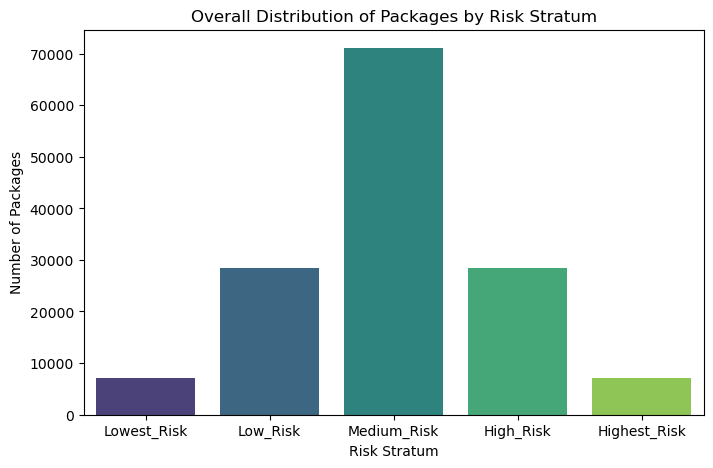

In [6]:
if 'stratified_df' in locals() and stratified_df is not None and stratum_col_name in stratified_df.columns:
    print_stratum_distribution(stratified_df, stratum_col_name, strata_config['labels'],
                               description="Overall Dataset")

    plt.figure(figsize=(8, 5))
    sns.countplot(data=stratified_df, x=stratum_col_name, order=strata_config['labels'], palette="viridis")
    plt.title('Overall Distribution of Packages by Risk Stratum')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Number of Packages')
    plt.show()
else:
    print("Skipping Overall Analysis: stratified_df not available or stratum column missing.")

## EDA

### Overall Stratum Distribution 


--- Overall Actual 'Good' Rate per Risk Stratum ---
                Total_Packages  Actual_Good_Rate
stratum_class0                                  
Lowest_Risk               7109          0.945140
Low_Risk                 28436          0.926537
Medium_Risk              71088          0.811572
High_Risk                28435          0.671321
Highest_Risk              7109          0.594739


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6133/3161144873.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_actual_quality_summary = stratified_df.groupby(stratum_col_name)['ActualQuality'].agg(


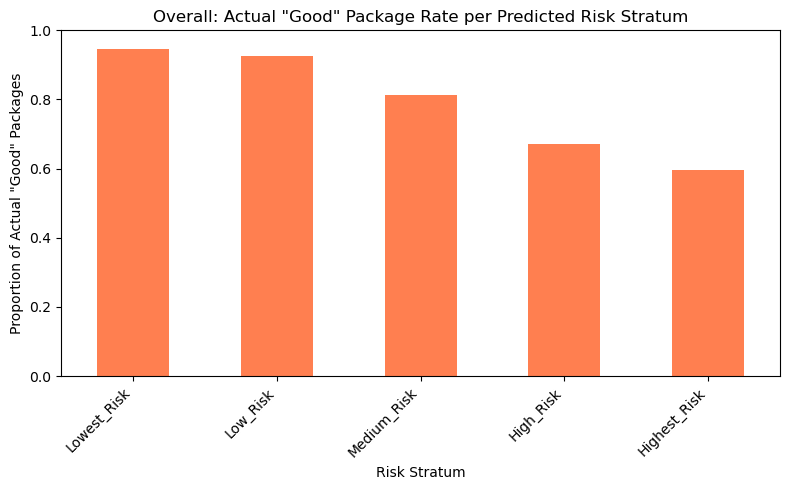

In [7]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'ActualQuality' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    overall_actual_quality_summary = stratified_df.groupby(stratum_col_name)['ActualQuality'].agg(
        Total_Packages='count',
        Actual_Good_Rate='mean'
    ).reindex(strata_config['labels'])

    print("\n--- Overall Actual 'Good' Rate per Risk Stratum ---")
    print(overall_actual_quality_summary)

    if not overall_actual_quality_summary['Actual_Good_Rate'].isnull().all():
        plt.figure(figsize=(8, 5))
        overall_actual_quality_summary['Actual_Good_Rate'].plot(kind='bar', color='coral')
        plt.title('Overall: Actual "Good" Package Rate per Predicted Risk Stratum')
        plt.xlabel('Risk Stratum')
        plt.ylabel('Proportion of Actual "Good" Packages')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
else:
    print("Skipping Overall Actual Quality Analysis: relevant columns missing.")



/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6133/3589537218.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  supplier_composition_in_strata = stratified_df.groupby([stratum_col_name, 'SupplierName']).size().reset_index(name='Package_Count')
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6133/3589537218.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  stratum_supplier_pivot = supplier_composition_in_strata.pivot_table(


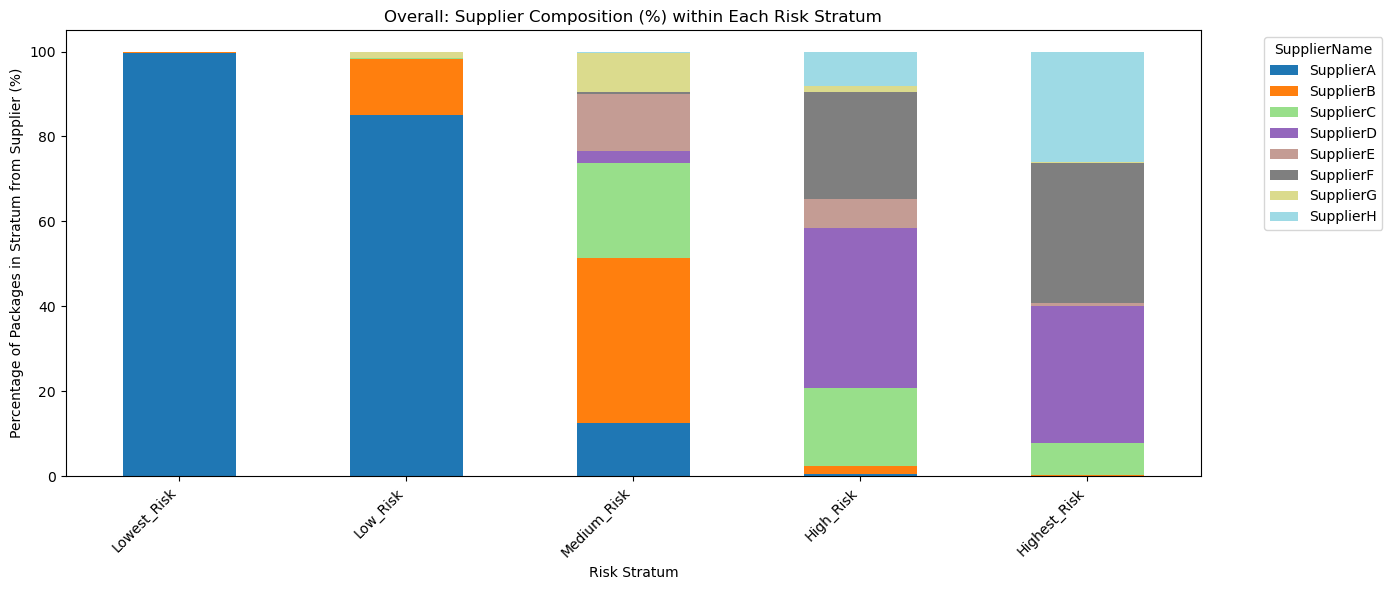

In [8]:
# Group by stratum, then by supplier, and count packages
supplier_composition_in_strata = stratified_df.groupby([stratum_col_name, 'SupplierName']).size().reset_index(name='Package_Count')
# For a cleaner plot, let's pivot and then normalize to get percentages
stratum_supplier_pivot = supplier_composition_in_strata.pivot_table(
    index=stratum_col_name,
    columns='SupplierName',
    values='Package_Count',
    fill_value=0
)

# Normalize across each row (stratum) to get percentage contribution of each supplier to that stratum
stratum_supplier_percentage = stratum_supplier_pivot.apply(lambda x: (x / x.sum()) * 100, axis=1)
stratum_supplier_percentage = stratum_supplier_percentage.reindex(strata_config['labels']) # Ensure order

# Plotting can be tricky if many suppliers. Let's plot for a manageable number of suppliers,
# e.g., top N suppliers overall or suppliers with significant presence.
# For simplicity here, we'll plot all, which might be dense.
if not stratum_supplier_percentage.empty:
    num_suppliers_to_plot = stratum_supplier_percentage.shape[1]
    plot_height = max(6, num_suppliers_to_plot * 0.5) # Adjust height based on num suppliers

    stratum_supplier_percentage.plot(
        kind='bar',
        stacked=True,
        figsize=(14, plot_height), # Adjust size as needed
        colormap='tab20' # Or another colormap like 'Paired', 'Set3'
    )
    plt.title('Overall: Supplier Composition (%) within Each Risk Stratum')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Percentage of Packages in Stratum from Supplier (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='SupplierName', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for supplier composition.")

#### Suppliers

In [9]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'SupplierName' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("OVERALL SUPPLIER COMPOSITION WITHIN EACH RISK STRATUM " )

    # --- Option 1: Table showing top N suppliers per stratum ---
    print("Top Suppliers Contributing to Each Risk Stratum (by Package Count)")
    for stratum_label in strata_config['labels']:
        print(f"\n  Stratum: {stratum_label}")
        top_suppliers_in_stratum = supplier_composition_in_strata[
            supplier_composition_in_strata[stratum_col_name] == stratum_label
        ].sort_values(by='Package_Count', ascending=False).head(5) # Show top 5 for brevity
        if not top_suppliers_in_stratum.empty:
            # Calculate percentage within this stratum for these top suppliers
            total_packages_in_stratum = stratified_df[stratified_df[stratum_col_name] == stratum_label].shape[0]
            top_suppliers_in_stratum['Percentage_of_Stratum'] = \
                (top_suppliers_in_stratum['Package_Count'] / total_packages_in_stratum) * 100
            print(top_suppliers_in_stratum[['SupplierName', 'Package_Count', 'Percentage_of_Stratum']].to_string(index=False))
        else:
            print("    No suppliers found in this stratum (or stratum is empty).")


OVERALL SUPPLIER COMPOSITION WITHIN EACH RISK STRATUM 
Top Suppliers Contributing to Each Risk Stratum (by Package Count)

  Stratum: Lowest_Risk
SupplierName  Package_Count  Percentage_of_Stratum
   SupplierA           7083              99.634266
   SupplierG             14               0.196933
   SupplierB             12               0.168800
   SupplierC              0               0.000000
   SupplierD              0               0.000000

  Stratum: Low_Risk
SupplierName  Package_Count  Percentage_of_Stratum
   SupplierA          24194              85.082290
   SupplierB           3769              13.254326
   SupplierG            421               1.480518
   SupplierE             29               0.101983
   SupplierC             20               0.070333

  Stratum: Medium_Risk
SupplierName  Package_Count  Percentage_of_Stratum
   SupplierB          27600              38.825118
   SupplierC          15797              22.221753
   SupplierE           9442              13.

In [10]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'SupplierName' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("\n\n--- Overall Dataset: Supplier Risk Profile Summary Table ---")
    supplier_summary_list = []
    unique_suppliers = sorted(stratified_df['SupplierName'].unique())

    for supplier_name_iter in unique_suppliers: # Renamed to avoid conflict with filter_supplier_name
        supplier_df_iter = stratified_df[stratified_df['SupplierName'] == supplier_name_iter]
        if supplier_df_iter.empty:
            continue

        summary = {'SupplierName': supplier_name_iter, 'TotalPackages': len(supplier_df_iter)}
        
        # Percentage of THIS SUPPLIER's packages in each global stratum
        stratum_dist_for_supplier = supplier_df_iter[stratum_col_name].value_counts(normalize=True).reindex(strata_config['labels'], fill_value=0) * 100
        for label in strata_config['labels']:
            summary[f'%_in_{label}'] = stratum_dist_for_supplier.get(label, 0.0)

        if 'ActualQuality' in supplier_df_iter.columns:
            summary['Overall_Actual_Good_Rate'] = supplier_df_iter['ActualQuality'].mean() * 100 # As percentage
            # Actual good rate in specific strata for this supplier
            highest_risk_label = strata_config['labels'][0] # Assumes first label is highest risk
            lowest_risk_label = strata_config['labels'][-1] # Assumes last label is lowest risk

            for risk_label_iter in [highest_risk_label, lowest_risk_label]: # Renamed for clarity
                 stratum_subset = supplier_df_iter[supplier_df_iter[stratum_col_name] == risk_label_iter]
                 if not stratum_subset.empty:
                     summary[f'Actual_Good_Rate_in_{risk_label_iter}'] = stratum_subset['ActualQuality'].mean() * 100
                 else:
                     summary[f'Actual_Good_Rate_in_{risk_label_iter}'] = np.nan
        supplier_summary_list.append(summary)

    supplier_overview_table = pd.DataFrame(supplier_summary_list)
    
    # Example: Sort by percentage in the 'Highest_Risk' stratum
    highest_risk_col_name_for_sort = f"%_in_{strata_config['labels'][0]}" # Assumes first label is highest risk
    if highest_risk_col_name_for_sort in supplier_overview_table.columns:
        sorted_supplier_overview = supplier_overview_table.sort_values(by=highest_risk_col_name_for_sort, ascending=False)
    else:
        sorted_supplier_overview = supplier_overview_table # Fallback

    print(f"Displaying overview for {len(sorted_supplier_overview)} suppliers (sorted by % in '{strata_config['labels'][0]}'):")
    # Format percentages for display
    percent_cols = [col for col in sorted_supplier_overview.columns if '%' in col or 'Rate' in col]
    styled_table = sorted_supplier_overview.style.format({col: '{:.2f}%' for col in percent_cols}, na_rep='-')
    
    # To print styled table in notebook (might be long, consider .head()):
    # display(styled_table) # Use display for Styler objects
    print(sorted_supplier_overview.to_string(index=False, float_format="%.2f")) # Simpler print, less pretty for %

else:
    print("Skipping Supplier Overview Table: relevant columns missing in stratified_df.")



--- Overall Dataset: Supplier Risk Profile Summary Table ---
Displaying overview for 8 suppliers (sorted by % in 'Lowest_Risk'):
SupplierName  TotalPackages  %_in_Lowest_Risk  %_in_Low_Risk  %_in_Medium_Risk  %_in_High_Risk  %_in_Highest_Risk  Overall_Actual_Good_Rate  Actual_Good_Rate_in_Lowest_Risk  Actual_Good_Rate_in_Highest_Risk
   SupplierA          40410             17.53          59.87             22.18            0.41               0.01                     91.79                            94.55                            100.00
   SupplierG           7356              0.19           5.72             88.42            5.49               0.18                     82.79                            85.71                             84.62
   SupplierB          31923              0.04          11.81             86.46            1.65               0.04                     84.99                            83.33                             78.57
   SupplierC          21534              



--- Overall Dataset: Supplier Risk Profile Distribution (Chart) ---


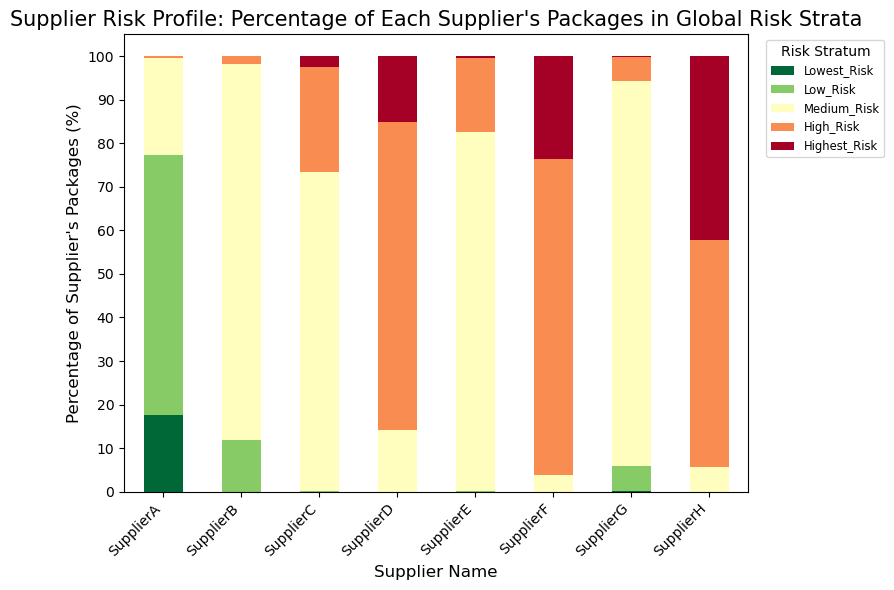

In [11]:
if 'supplier_overview_table' in locals() and not supplier_overview_table.empty:
    print("\n\n--- Overall Dataset: Supplier Risk Profile Distribution (Chart) ---")
    
    # Select only the percentage columns for the strata and SupplierName
    strata_percentage_columns = [f"%_in_{label}" for label in strata_config['labels']]
    
    # Check if all expected percentage columns are in the table
    missing_cols = [col for col in strata_percentage_columns if col not in supplier_overview_table.columns]
    if missing_cols:
        print(f"Warning: Missing percentage columns for plotting: {missing_cols}")
        # Proceed with available columns, or handle error
        strata_percentage_columns = [col for col in strata_percentage_columns if col in supplier_overview_table.columns]

    if not strata_percentage_columns:
        print("No strata percentage columns found to plot.")
    else:
        # Set SupplierName as index for easier plotting
        plot_df = supplier_overview_table.set_index('SupplierName')[strata_percentage_columns].copy()
        
        # Rename columns for a cleaner legend (optional, but good practice)
        # Current names: %_in_Lowest_Risk, etc. We want: Lowest_Risk, etc.
        plot_df.columns = [col.replace('%_in_', '') for col in plot_df.columns]
        
        # Ensure the columns are in the desired stratum order for stacking
        # (strata_config['labels'] should provide this order)
        ordered_strata_labels_for_plot = [label for label in strata_config['labels'] if label in plot_df.columns]
        plot_df = plot_df[ordered_strata_labels_for_plot]

        # Determine number of suppliers for plot height adjustment
        num_suppliers = len(plot_df)
        plot_height = max(6, num_suppliers * 0.35) # Adjust multiplier as needed
        plot_width = max(10, num_suppliers * 0.8) # Adjust width

        plot_df.plot(
            kind='bar',
            stacked=True,
            figsize=(min(plot_width, 20), plot_height), # Cap width
            colormap='RdYlGn_r' # Red-Yellow-Green reversed: Red for Highest_Risk, Green for Lowest_Risk
                               # (Assumes strata_config['labels'] is [Highest, High, Med, Low, Lowest])
                               # If your labels are [Lowest, Low,...Highest], use 'RdYlGn'
        )
        
        plt.title('Supplier Risk Profile: Percentage of Each Supplier\'s Packages in Global Risk Strata', fontsize=15)
        plt.xlabel('Supplier Name', fontsize=12)
        plt.ylabel('Percentage of Supplier\'s Packages (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(np.arange(0, 101, 10)) # Y-ticks from 0 to 100
        plt.legend(title='Risk Stratum', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect for legend
        plt.show()
else:
    print("Skipping Supplier Risk Profile Chart: `supplier_overview_table` not found or is empty.")

#### Garments

In [22]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'GarmentType' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("\n\n--- Overall Dataset: How Each Garment Type Distributes Across Risk Strata ---")

    # Group by GarmentType, then by stratum, and count packages
    garment_strata_distribution = stratified_df.groupby(['GarmentType', stratum_col_name]) \
                                      .size().reset_index(name='Package_Count')

    # Pivot to have GarmentType as index, strata as columns
    garment_pivot = garment_strata_distribution.pivot_table(
        index='GarmentType',
        columns=stratum_col_name,
        values='Package_Count',
        fill_value=0
    )

    # Ensure all strata labels are columns, even if a garment type has 0 in some
    for label in strata_config['labels']:
        if label not in garment_pivot.columns:
            garment_pivot[label] = 0
    garment_pivot = garment_pivot[strata_config['labels']] # Order columns

    # Normalize across each row (GarmentType) to get percentages
    garment_strata_percentage = garment_pivot.apply(lambda x: (x / x.sum()) * 100, axis=1)
    
    # Add total count for context
    garment_totals = stratified_df['GarmentType'].value_counts()
    garment_strata_percentage['Total_Packages_for_GarmentType'] = garment_totals
    
    # Sort by total packages or by percentage in a key stratum for better viewing
    # Example: sort by percentage in the 'Highest_Risk' stratum
    highest_risk_label = strata_config['labels'][0] # Assuming first label is highest risk
    if highest_risk_label in garment_strata_percentage.columns:
        sorted_garment_strata_percentage = garment_strata_percentage.sort_values(
            by=highest_risk_label, ascending=False
        )
    else:
        sorted_garment_strata_percentage = garment_strata_percentage.sort_values(
            by='Total_Packages_for_GarmentType', ascending=False
        )


    print(sorted_garment_strata_percentage.to_string(float_format="%.2f%%")) # Print the table




--- Overall Dataset: How Each Garment Type Distributes Across Risk Strata ---
stratum_class0  Lowest_Risk  Low_Risk  Medium_Risk  High_Risk  Highest_Risk  Total_Packages_for_GarmentType
GarmentType                                                                                                
Shorts                7.50%    19.19%       51.70%     18.06%         3.56%                            7537
Shirt                 7.33%    19.11%       49.77%     19.97%         3.81%                           29099
Blouse                7.32%    19.84%       48.63%     18.80%         5.41%                            6547
Sweater               6.72%    18.31%       51.59%     19.26%         4.12%                            6625
T-Shirt               5.07%    22.73%       49.89%     18.54%         3.77%                           13739
Hoodie                4.89%    19.78%       46.48%     19.09%         9.76%                            3741
Jacket                4.21%    20.68%       49.58%     2

/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6133/549039911.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  garment_strata_distribution = stratified_df.groupby(['GarmentType', stratum_col_name]) \
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6133/549039911.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  garment_pivot = garment_strata_distribution.pivot_table(


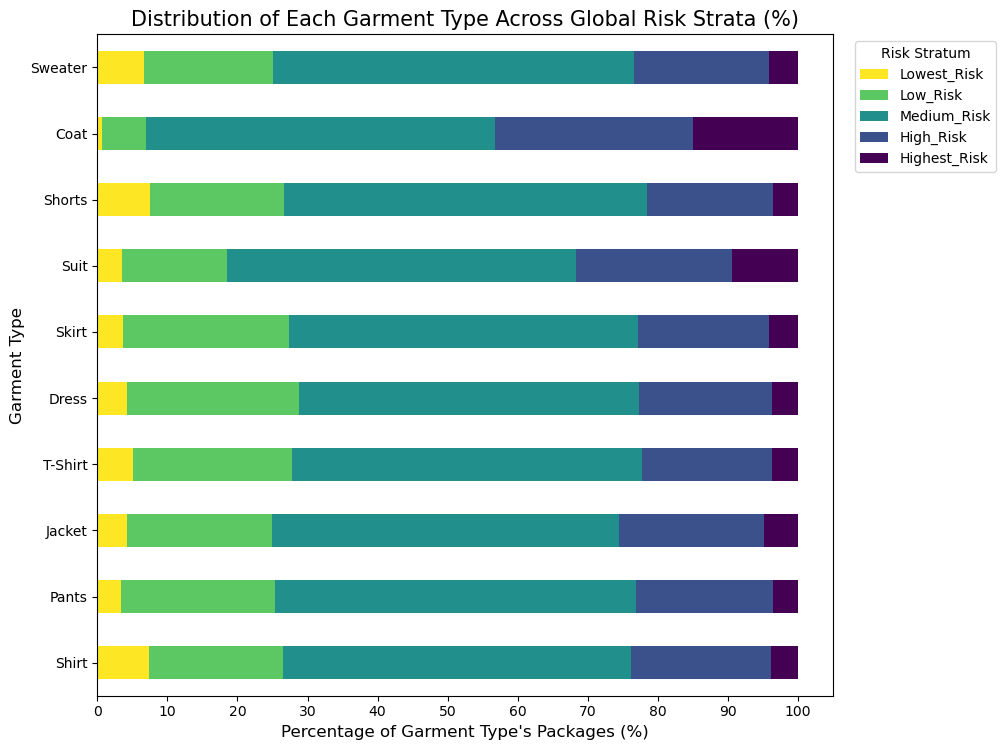

In [23]:
top_n_garments_for_plot = garment_totals.nlargest(10).index
plot_df_garment_dist = sorted_garment_strata_percentage.loc[top_n_garments_for_plot, strata_config['labels']]

if not plot_df_garment_dist.empty:
        plot_df_garment_dist.plot(
            kind='barh', # Horizontal bar chart can be good here
            stacked=True,
            figsize=(12, max(8, len(top_n_garments_for_plot) * 0.6)),
            colormap='viridis_r' # Example colormap
        )
        plt.title('Distribution of Each Garment Type Across Global Risk Strata (%)', fontsize=15)
        plt.xlabel('Percentage of Garment Type\'s Packages (%)', fontsize=12)
        plt.ylabel('Garment Type', fontsize=12)
        plt.xticks(np.arange(0, 101, 10))
        plt.legend(title='Risk Stratum', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0.05, 0.85, 1])
        plt.show()
else:
      print("Skipping Garment Type Distribution Across Strata: relevant columns missing.")

#### Weight



--- Overall Dataset: Average Package Weight per Risk Stratum ---
                Average_Weight  Median_Weight  Package_Count
stratum_class0                                              
Lowest_Risk           0.373735           0.28           7109
Low_Risk              0.408799           0.32          28436
Medium_Risk           0.458591           0.33          71088
High_Risk             0.492091           0.35          28435
Highest_Risk          0.648766           0.49           7109


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6133/353850129.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_weight_per_stratum = stratified_df.groupby(stratum_col_name)['Weight'].agg(


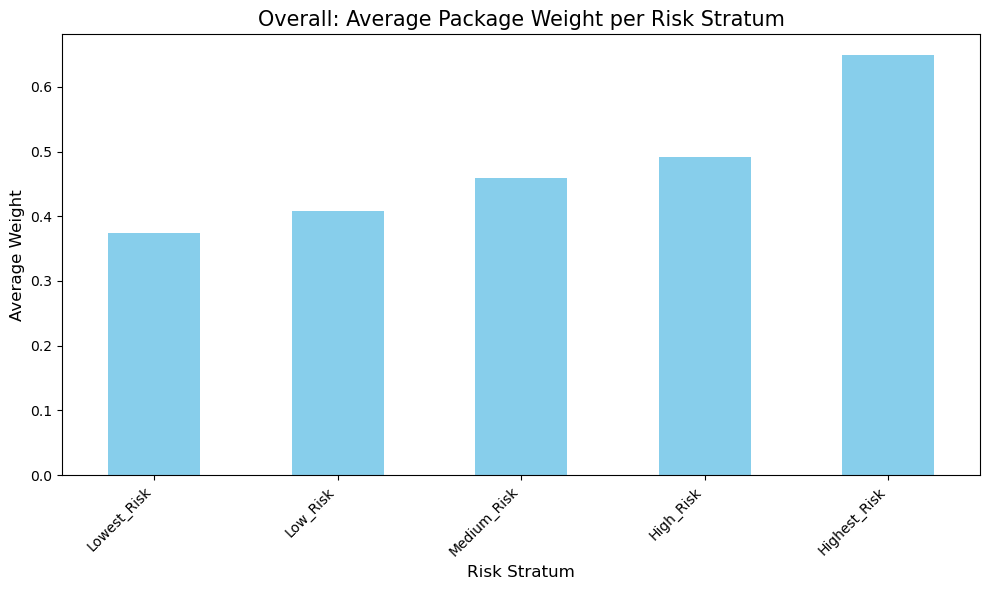

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


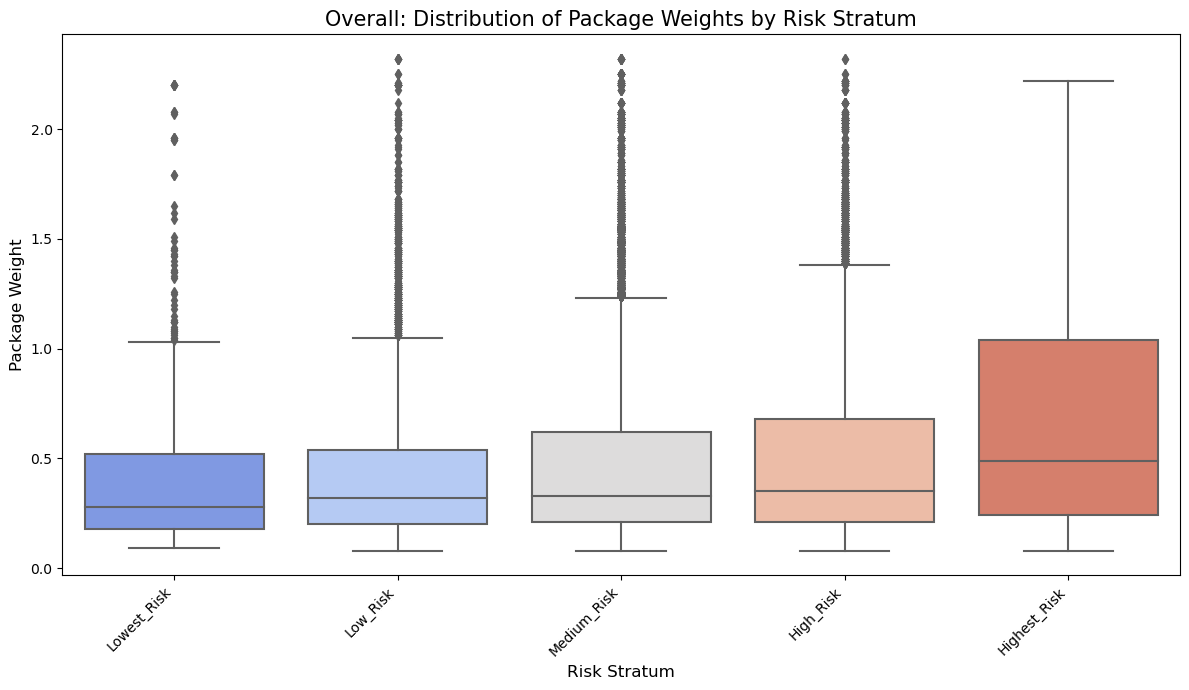

In [25]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'Weight' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("\n\n--- Overall Dataset: Average Package Weight per Risk Stratum ---")
    avg_weight_per_stratum = stratified_df.groupby(stratum_col_name)['Weight'].agg(
        Average_Weight='mean',
        Median_Weight='median',
        Package_Count='count'
    ).reindex(strata_config['labels'])
    print(avg_weight_per_stratum)

    if not avg_weight_per_stratum['Average_Weight'].isnull().all():
        plt.figure(figsize=(10, 6))
        avg_weight_per_stratum['Average_Weight'].plot(kind='bar', color='skyblue', yerr=avg_weight_per_stratum.get('Std_Dev_Weight')) # Optional error bars if you calculate std
        plt.title('Overall: Average Package Weight per Risk Stratum', fontsize=15)
        plt.xlabel('Risk Stratum', fontsize=12)
        plt.ylabel('Average Weight', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Box plot for more detail on distribution
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=stratified_df, x=stratum_col_name, y='Weight', order=strata_config['labels'], palette='coolwarm')
        plt.title('Overall: Distribution of Package Weights by Risk Stratum', fontsize=15)
        plt.xlabel('Risk Stratum', fontsize=12)
        plt.ylabel('Package Weight', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("Skipping Weight Analysis: 'Weight' or stratum column missing.")